In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Tuple

In [2]:
# experiment_folder = "/home/kenzo/experiments/alexnet-pretrained-50ep/"
# experiment_folder = "/home/kenzo/experiments/resnet18-pretrained-50ep/"
# experiment_folder = "/home/kenzo/experiments/vggnet11pretrained-50ep/"
# experiment_folder = "/home/kenzo/experiments/vggnet11pretrained-50ep/"
experiment_folder = "/home/kenzo/experiments/alexnet-pretrained-super_aug-50ep/"


# Loss final de cada fold

In [3]:
summarized_fold_info_df = pd.read_csv(experiment_folder + "summarized_fold_info.csv")
summarized_fold_info_df.set_index("fold", inplace=True)


&lt;matplotlib.axes._subplots.AxesSubplot at 0x7fa2b1978e48&gt;

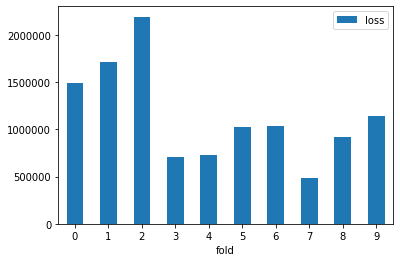

In [4]:
summarized_fold_info_df.plot.bar(rot=0)

# Predições

In [5]:
def scatter_plot_and_save(experiment_name: str,
                          real: Tuple,
                          pred: Tuple) -> None:

    plt.figure()

    # controls default text sizes
    # plt.rc('font', size=16)          

    # hard-coding axis' max values [xmin, xmax, ymin, ymax]
    # plt.axis([0, 15000, 0, 17500])

    plt.xlabel("REAL")
    plt.ylabel("PREDICTION")

    plt.plot(real, pred, 'co')    
    dashes = [5, 5, 5, 5]
    
    plt.plot(real, real, dashes=dashes, color="#cccccc")

In [6]:
import matplotlib.patches as mpatches 
import numpy as np

def calc_intersections(hist1, hist2) -> float:
    s = 0
    for p in zip(hist1, hist2):
        s += min(p)
    
    return s

def plot_and_save_histogram(experiment_name: str,
                            real: Tuple, 
                            pred: Tuple, 
                            bins: int, 
                            weights=None) -> None:
    plt.figure()
   
    weights = np.ones(len(real)) / len(real)

    range_min = min(np.min(real), np.min(pred))
    range_max = max(np.max(real), np.max(pred))

    full_range = (range_min, range_max)

    n1, bins, _ = plt.hist(real, bins=bins,
                                 range=full_range,
                                 weights=weights, 
                                 facecolor="#34a2eb",
                                 edgecolor="#2c5aa3",
                                 alpha=0.9)
    
    n2, bins, _ = plt.hist(pred, bins=bins, 
                                 range=full_range,
                                 weights=weights,
                                 facecolor="#ffbc47",
                              #    edgecolor="#9e742b", 
                                 alpha=0.6)
    
    real_patch = mpatches.Patch(color='#34a2eb', label='y')
    pred_patch = mpatches.Patch(color='#ffbc47', label='ŷ')
    plt.legend(handles=[real_patch, pred_patch])
    
    intersection = calc_intersections(n1, n2)
    print(intersection)

In [7]:
predictions_df = pd.read_csv(experiment_folder + "predictions.csv")
predictions_df.head()

,test_index,prediction,real_value
0,293,6613.107910,6667.0
1,22,7419.649902,5778.0
2,212,4451.339355,3778.0
3,146,10378.050781,9556.0
4,234,4276.454102,5333.0


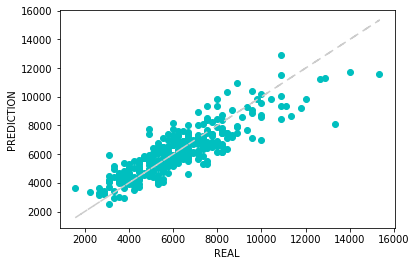

In [8]:
scatter_plot_and_save("Model", predictions_df["real_value"].values, predictions_df["prediction"].values)

0.8606060606060619


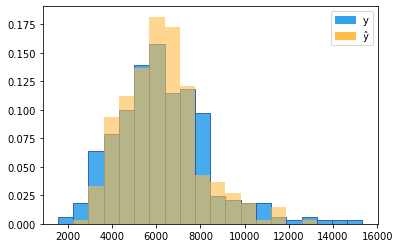

In [9]:
plot_and_save_histogram("Model", predictions_df["real_value"].values, predictions_df["prediction"].values, 20)

# Análise dos folds

In [10]:
raw_fold_info_df = pd.read_csv(experiment_folder + "raw_fold_info.csv")
raw_fold_info_df.head()

,fold,epoch,train_loss,validation_loss
0,0,0,7.060508e+06,4.170034e+06
1,0,1,2.529596e+06,1.776783e+06
2,0,2,1.860410e+06,1.331978e+06
3,0,3,1.539006e+06,1.800613e+06
4,0,4,1.173046e+06,1.969283e+06


## Loss média de cada época do k-fold

In [11]:
def get_avg_validation_loss(raw_fold_info_df: pd.DataFrame) -> pd.DataFrame:
    
    folds = len(raw_fold_info_df["fold"].unique())

    new_df = raw_fold_info_df[["epoch", "train_loss", "validation_loss"]].groupby("epoch").sum()
    new_df["train_loss"] /= folds
    new_df["validation_loss"] /= folds

    return new_df

In [12]:
teste = get_avg_validation_loss(raw_fold_info_df)

In [13]:
teste.reset_index()

,epoch,train_loss,validation_loss
0,0,5.833556e+06,2.544909e+06
1,1,2.479949e+06,1.914478e+06
2,2,1.822350e+06,1.291018e+06
3,3,1.618291e+06,1.459115e+06
4,4,1.428667e+06,1.291791e+06
5,5,1.251410e+06,1.324130e+06
6,6,1.104650e+06,1.254277e+06
7,7,1.064812e+06,1.407269e+06
8,8,1.038153e+06,1.401040e+06
9,9,9.631316e+05,9.393059e+05


&lt;matplotlib.axes._subplots.AxesSubplot at 0x7fa2ad7d4f60&gt;

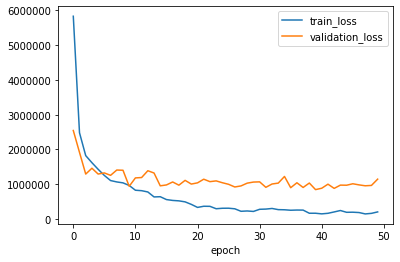

In [14]:
teste.plot()

## Analisando um fold em específico

In [15]:
fold = 1

In [16]:
fold_df = raw_fold_info_df[raw_fold_info_df["fold"] == fold]
fold_df.drop(columns="fold", inplace=True)
fold_df.set_index("epoch", inplace=True)
fold_df.head()

,train_loss,validation_loss
epoch,,
0,6.988553e+06,5.030427e+06
1,2.151161e+06,1.710852e+06
2,1.780448e+06,1.765193e+06
3,1.253707e+06,1.372171e+06
4,1.219310e+06,1.396728e+06


&lt;matplotlib.axes._subplots.AxesSubplot at 0x7fa2ac75f860&gt;

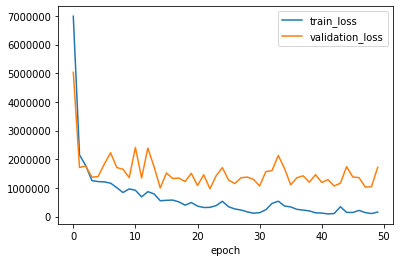

In [17]:
fold_df.plot()

# Comparando todos os experimentos

In [18]:
experiment_folder = "/home/kenzo/experiments/"

In [19]:
def get_all_experiments_avg_validation_loss(experiment_folder: str, show_model_names: bool = True):

    experiments_df = pd.DataFrame(columns=["epoch", "train_loss", "validation_loss", "model"])

    for experiment in os.listdir(experiment_folder):
        for root, dirs, files in os.walk(experiment_folder+experiment):
            for file_name in files:

                if "raw_fold_info.csv" in file_name:

                    raw_info_df = pd.read_csv(os.path.join(experiment_folder, experiment, file_name))
                    experiment_avg_loss = get_avg_validation_loss(raw_info_df).reset_index()
                    experiment_avg_loss["model"] = experiment

                    experiments_df = experiments_df.append(experiment_avg_loss, ignore_index=True)

    models = experiments_df["model"].unique()
    models.sort()
    aliases = {name: f"#{i}" for i, name in enumerate(models, start=1)}

    if not show_model_names:
        experiments_df.replace(aliases, inplace=True)
    
    return experiments_df, aliases

In [20]:
df, aliases = get_all_experiments_avg_validation_loss(experiment_folder, show_model_names=False)

In [21]:
aliases

{&#39;alexnet-pretrained-50ep&#39;: &#39;#1&#39;,
 &#39;alexnet-pretrained-super_aug-200ep&#39;: &#39;#2&#39;,
 &#39;alexnet-pretrained-super_aug-50ep&#39;: &#39;#3&#39;,
 &#39;resnet18-pretrained-50ep&#39;: &#39;#4&#39;,
 &#39;resnet18-pretrained-super_aug-50ep&#39;: &#39;#5&#39;,
 &#39;vggnet11pretrained-50ep&#39;: &#39;#6&#39;}

In [22]:
df = df[["epoch", "validation_loss", "model"]]
# df = df[df["epoch"] < 10] # filtrando epocas
df.set_index("epoch", inplace=True)
df = df.pivot(columns="model")

Text(0.5, 0, &#39;Epochs&#39;)

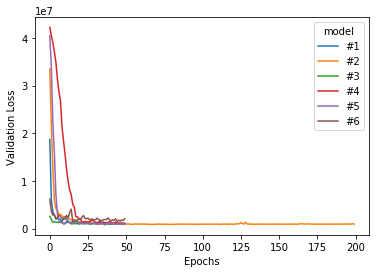

In [23]:
df["validation_loss"].plot()
plt.ylabel("Validation Loss")
plt.xlabel("Epochs")